# Introduction
Author: Adam Kacprzycki - Warsaw University of Technology - Data Science Postgraduate Study - group no. : 1, index no. : p-8731
________

**Sentiment Analysis:** <br>
It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook will develop a **Sentiment Analysis model** to categorize IMDB reviews as **Positive or Negative.**


## Importing libaries
_______

In [1]:
# basis
import re
import pickle
import numpy as np
import pandas as pd
import contractions
import string
import time
import os


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text as txt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Get the current working directory (cwd)
cwd = os.getcwd()
cwd

'/Users/adamkacprzycki'

## Importing dataset
__________
The dataset being used contain  50 000 IMDB reviews. The reviews have been annotated as negative and positive and they can be used to detect sentiment.

**It contains the following 2 fields:**
1. **review**: the text of review
2. **sentiment**: the polarity of the review - negative or positive

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(Negative, Positive)**

In [3]:
# Importing the dataset
DATASET_COLUMNS  = ["review", "sentiment"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('IMDB Dataset.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS, header = 0)

# Storing data in lists.
review, sentiment = list(dataset['review']), list(dataset['sentiment'])

#Changing values of sentiment list to 1 - positive and 0 - negative.
sentiment = [1 if i == "positive" else 0 for i in sentiment]

In [4]:
# Distribution for dataset. Dataset is balanced.
dataset.groupby('sentiment').count()

,review
sentiment,
negative,25000
positive,25000


## Preprocess Text
___________
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Expanding contractions**: Replacing contractions eg. it's -> it is, ive -> i have
2. **Removing HTML tag** Replacing all items included <>.
3. **Replacing Emojis:** Replace emojis from the analyzed text.
4. **Lower Casing:** Each text is converted to lowercase.
5. **Tokenization:** Word tokenizer split each individual word into a token.
6. **Removing punctuation:** Punctuation serve little value for modeling.
7. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. Can be safely ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
8. **Stemming Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “better” to “good”)*

In [5]:
# Defining preprocessing data function to cover all above requiremens:

def prep_engine(l: list):
    
    punctuation = string.punctuation
    wordNetLem = WordNetLemmatizer()
    stopwordlist = txt.ENGLISH_STOP_WORDS
    
    newlist = []

    for i in l:
        
        i = contractions.fix(i)
        
        i = re.sub('<[^>]*>', '', i)
        
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', i)
        
        i = re.sub('[\W]+', ' ', i.lower()) +\
            ' '.join(emoticons).replace('-', '')
        newlist.append(i)
       
    newSeries = pd.Series(newlist)
    
    newSeries = newSeries.apply(word_tokenize)
    
    newSeries = newSeries.apply(lambda token: [punc for punc in token if punc not in punctuation])
    
    newSeries = newSeries.apply(lambda token: [stop for stop in token if stop not in stopwordlist])
    
    newSeries = newSeries.apply(nltk.tag.pos_tag)
    
    def wordnet_pos(treebank_tag):

        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
            
    newSeries = newSeries.apply(lambda i: [(word, wordnet_pos(posTag)) for (word, posTag) in i])
    
    newSeries = newSeries.apply(lambda x: [wordNetLem.lemmatize(word, tag) for word, tag in x])
    
    newSeries = [' '.join(map(str,l)) for l in newSeries]
    
    return newSeries

In [6]:
#Execution of prep_engine function on loaded data:
t = time.time()

prep_data = prep_engine(review)

print(f'Execution time of "prep_engine" on data: {round(time.time()-t)} seconds')

Execution time of "prep_engine" on data: 271 seconds


## Analysing the data
_______
**Word Clouds** for **Positive and Negative** reviews from our dataset to see which words occur the most. Word Clouds work in a simple way: the more specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

In [7]:
df = pd.DataFrame(list(zip(prep_data, sentiment)),
               columns =['review', 'sentiment'])

In [8]:
#Subseting data for negative and positive reviews:
data_positive = df.query('sentiment == 1')["review"]
data_negative = df.query('sentiment == 0')["review"]

### Word-Cloud for negative IMDB reviews.

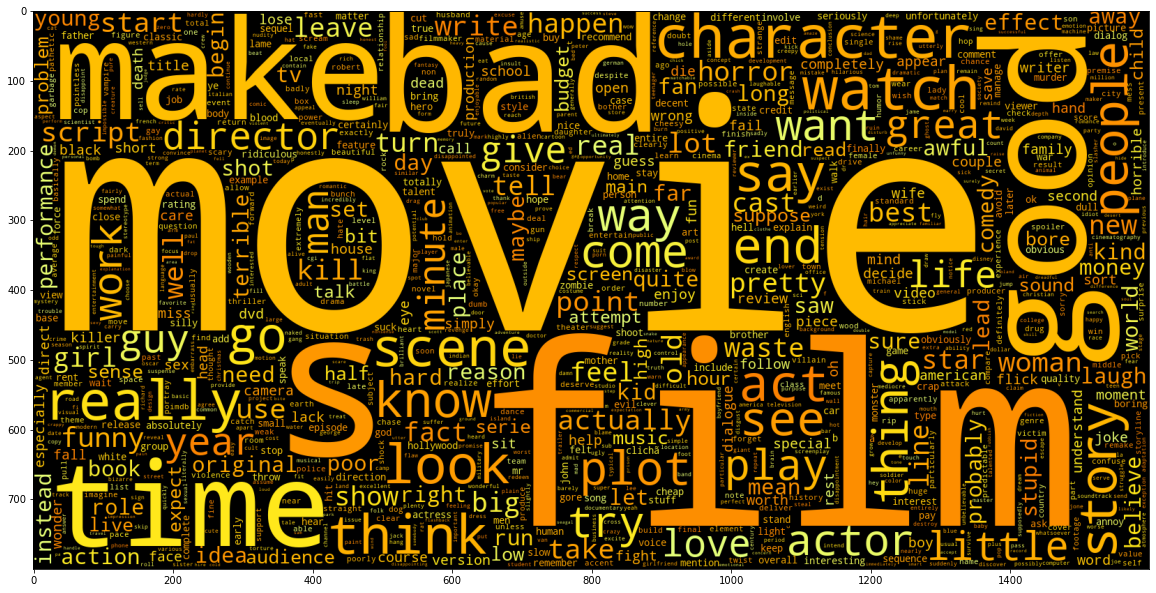

In [9]:
plt.figure(figsize = (20,20))
negative = WordCloud(max_words = 1000 , width = 1600 , height = 800, colormap="Wistia",
               collocations=False).generate(" ".join(data_negative))
plt.imshow(negative)

### Word-Cloud for IMDB positive reviews.

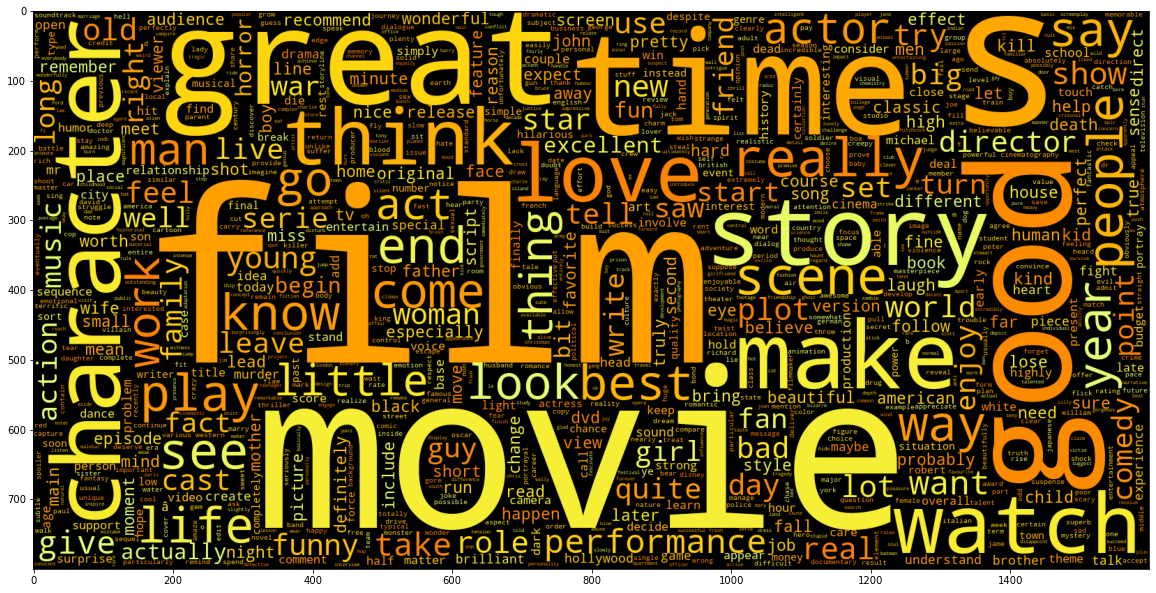

In [10]:
plt.figure(figsize = (20,20))
positive = WordCloud(max_words = 1000 , width = 1600 , height = 800, colormap="Wistia",
               collocations=False).generate(" ".join(data_positive))
plt.imshow(positive)

In [11]:
#Removing data frames used to build word cloud from memory:
del (df, data_positive, data_negative)

## Splitting the Data
The Preprocessed Data is divided into 2 sets of data: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 80% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 20% data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(prep_data, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data was splited.')

Data was splited.


## TF-IDF Vectoriser
___________
**TF-IDF** indicates what is the words importance to a given document in the present dataset or corpus.<br>

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**.

**ngram_range**  is the range of number of words in a sequence. *[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

info: <br>
https://medium.com/acing-ai/what-is-tf-idf-in-feature-engineering-7f1ba81982bd <br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [13]:
vectoriser_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features = 500000)
vectoriser_tfidf.fit(X_train)
print('Number of feature_words: ', len(vectoriser_tfidf.get_feature_names()))

Number of feature_words:  500000


### Tranforming the dataset
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [14]:
X_train = vectoriser_tfidf.transform(X_train)
X_test  = vectoriser_tfidf.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## Creating and Evaluating Models
______

We're creating 5 different types of model for our sentiment analysis problem: 
* **k-nearest neighbors (KNeighborsClassifier)**
* **Multinomial Naive Bayes classifier (MultinomialNB)**
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LogisticRegression)**

Dataset has equal number of positive and negative predictions. Final model will be chosen with  Accuracy metrics as final evaluation metric. Furthermore, there will be prepared plot of the confusion matrix to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [15]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'binary',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### KNeighborsClassifier
info: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      5035
           1       0.75      0.84      0.79      4965

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

Model was trained within: 26 seconds


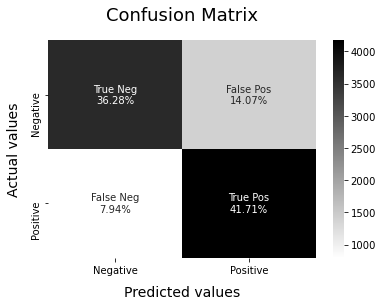

In [16]:
t = time.time()

KNModel = KNeighborsClassifier()
KNModel.fit(X_train, y_train)
model_Evaluate(KNModel)

print(f'Model was trained within: {round(time.time()-t)} seconds')

### MultinomialNB
info: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5035
           1       0.87      0.87      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Model was build within: 0 seconds


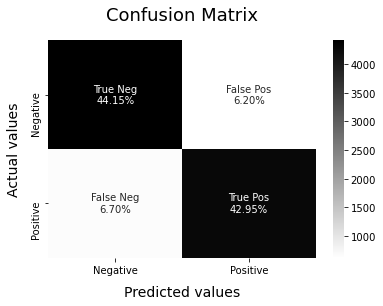

In [17]:
t = time.time()

MNBmodel = MultinomialNB(alpha = 2)
MNBmodel.fit(X_train, y_train)
model_Evaluate(MNBmodel)

print(f'Model was build within: {round(time.time()-t)} seconds')

### BernoulliNB Model
info: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5035
           1       0.88      0.85      0.86      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Model was build within: 0 seconds


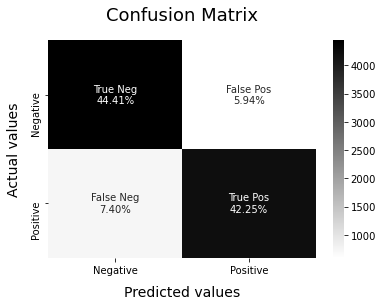

In [18]:
t = time.time()
    
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

print(f'Model was build within: {round(time.time()-t)} seconds')

### LinearSVC Model
info: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5035
           1       0.89      0.91      0.90      4965

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Model was build within: 1 seconds


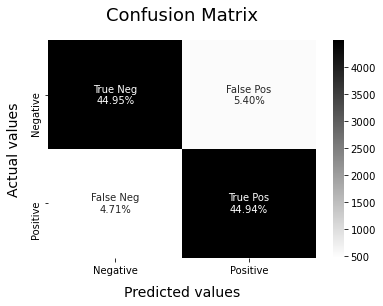

In [19]:
t = time.time()

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

print(f'Model was build within: {round(time.time()-t)} seconds')

### Logistic Regression Model
info: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5035
           1       0.88      0.90      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Model was build within: 9 seconds


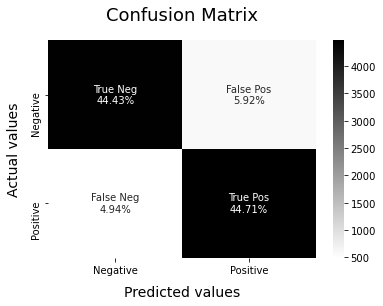

In [20]:
t = time.time()

LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

print(f'Model was build within: {round(time.time()-t)} seconds')

### Conclusion
It is clear that the **Linear Support Vector Classification (LinearSVC)** performs the best out of all the different models that were tried. It achieves nearly **90% accuracy** while classifying the sentiment of a IMDB reviews and that model was the fastes to train and predict on.

## Saving the Models
______
 Pickle lib gives opportiunity to save trained model. Top 3 models: i. LinearSVC, ii. LogisticRegression and iii. BernoulliNB will be saved for later use.

In [21]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser_tfidf, file)
file.close()

file = open('Sentiment-SVCL.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-LRmodel.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB_v2.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

## Using the Model.
________
To use the model for sentiment prediction, it is needed to import the TF-IDF Vectoriser and LinearSVC Model using pickle lib.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [22]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser_Tfidf = pickle.load(file)
    file.close()
    
    # Load the LinearSVC.
    file = open('Sentiment-SVCL.pickle', 'rb')
    SVCLmodel = pickle.load(file)
    file.close()
    
    return vectoriser_Tfidf, SVCLmodel

def predict_sentiment(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser_Tfidf.transform(prep_engine(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [26]:
# Loading the models.
vectoriser_Tfidf, SVCLmodel = load_models()
    
# Text to classify should be in a list.
random_text = ["Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
                "@Hegelbon That heart sliding into the waste basket. :(",
                "I love chocolate",
                "Dumb bi***",
                "It was a pleasure!",
                "Thank you for your attention!!"]
    
df = predict_sentiment(vectoriser_Tfidf, SVCLmodel, random_text)
print(df)

                                                text sentiment
0  Everything in the kids section of IKEA is so c...  Negative
1  @Hegelbon That heart sliding into the waste ba...  Negative
2                                   I love chocolate  Positive
3                                         Dumb bi***  Negative
4                                 It was a pleasure!  Positive
5                     Thank you for your attention!!  Positive
